<a href="https://colab.research.google.com/github/Sreetam/tamarindncilantro/blob/main/Cilantro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip3 install wwo-hist
# !pip3 install geopy

In [2]:
import numpy as np
import pandas as pd
import math
from geopy.geocoders import Nominatim
from wwo_hist import retrieve_hist_data
import geopy.distance
from numpy.lib.type_check import nan_to_num
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/Sreetam/tamarindncilantro/main/city.csv")
for i in df.columns:
  df[i] = df[i].replace({ "Ab" : 0.5, "yes" : 1, "no" : 0})
# calling the Nominatim tool
loc = Nominatim(user_agent="GetLoc")

In [4]:
regions = dict()
for i in df['city']:
  # entering the location name
  getLoc = loc.geocode(i + " County, New York, USA", timeout=10)
  # printing address
  regions[i] = [getLoc.latitude, getLoc.longitude]
  #print(getLoc.address, regions[i])
  

In [5]:
# frequency = 24
# avl = []
# start_date = '24-JUNE-2009'
# end_date = '25-JUNE-2009'
# api_key = 'd53f19519ce445af91c102914222202'
# for i in df['city']:
#   location_list = [i]
#   try:
#     hist_weather_data = retrieve_hist_data(api_key, location_list, start_date, end_date, frequency, 
#                                           location_label = False, export_csv = True, store_df = True)
#     avl.append(i)
#   except:
#     pass
# nv = list(set(df['city']) - set(avl))
# df.loc[[i in nv for i in df['city']]]

In [6]:
# x = np.linspace(0, 10, 100)
# y = [(1 + np.exp(-i))**1 for i in x]
# plt.plot(x,y)
# plt.show()

In [ ]:
frequency = 24
start_date = '24-JUNE-2009'
end_date = '17-AUG-2009'
api_key = '7be3e38b915c466797954501222908'
# location_list = avl
location_list = df['city']
hist_weather_data = retrieve_hist_data(api_key, location_list, start_date, end_date, frequency, 
                                      location_label = False, export_csv = True, store_df = True)
# !cp ./*.csv ./drive/MyDrive/datacilantro/
!mv ./*.csv ./weather_data/
!mv ./weather_data/risk_pred.csv ./
!mv ./weather_data/city.csv ./

In [31]:
dat = ['date_time', 'humidity', 'tempC']
hist_weather_data = []
for i in location_list:
    hist_weather_data.append(pd.read_csv('./weather_data/'+i+'.csv')[dat])

In [8]:

for i in range(len(hist_weather_data)):
  hist_weather_data[i] = hist_weather_data[i][dat].reset_index(drop=True)

In [32]:
def getDat(atr, date):
  val = dict()
  for i in range(len(hist_weather_data)):
    # val[df['city'][i]] = 1/(1 + np.exp(-float(hist_weather_data[i][atr][date])/100))
    val[df['city'][i]] = float(hist_weather_data[i][atr][date])
  return val

In [33]:
# Higher weight means more probability of transmission
def calc_weight(x, y):
  d = geopy.distance.geodesic(regions[x], regions[y]).km
  if d==0: return 0
  return 1/(1 + np.exp(-1/d))

# Calculate the decay as per the formula
def find_decay():
    d = 0.6666667
    return np.array([[d, d]])

In [34]:
# The transmission graph contains info of the vector score, ie, weights
# between two nodes L1 and L2

class transmission_graph:
  # dense = []
  # susceptibility = dict()
  def __init__(self, sample=False):
    # n denotes the number of districts or nodes in the graph
    self.tempC = dict()
    self.humidity = dict()
    self.n = len(regions)
    self.city = list(regions.keys())
    # adj_matrix is the adjacency matrix
    # The ith row and jth column of the adjacency matrix
    # stores the weight of the edge between ith and jth node
    self.adj_matrix = dict()
    self.E = [[-1, -1], [-1, -1]]
    self.susceptibility = dict()
    self.initialize_matrix()

  # This function initialises the graph with nodes and stores weights between each node of the graph
  def initialize_matrix(self):
    # Iterate over each node in the graph
    for i in regions.keys():
      # Iterate over all the neighbours
      self.adj_matrix[i] = dict()
      for j in regions.keys():
        self.adj_matrix[i][j] = calc_weight(i, j)
    # Also assign the susceptibility value of each node
    self.compute_susceptibility(0)
  def compute_susceptibility(self, day):
    s = dict()
    self.tempC = getDat('tempC', day)
    self.humidity = getDat('humidity', day)
    # print(self.tempC['Albany'])
    for i in regions.keys():
        self.susceptibility[i] = self.calc_susceptibility_score(i)[0][0]
        s[i] = self.calc_susceptibility_score(i)[0][0]
        # if i=='Albany':
        #   print(self.calc_susceptibility_score(i)[0][0])
    return s
  # Function to modify the edge weight between two regions
  def change_weight(self, r1, r2, wt):
    self.adj_matrix[r1][r2] = wt
  def calc_susceptibility_score(self, node):
    Sn = np.array([[self.tempC[node], self.humidity[node]]])
    Sn = Sn.transpose()
    decay = find_decay()
    y = np.matmul(decay, Sn)
    # if node=='Albany':
    #   print(y)
    return y

In [35]:
g = transmission_graph()

In [36]:
susceptibility_df = dict()
# s_l = []
for i in range(len(hist_weather_data[0]['date_time'])):
  susceptibility_df[i] = g.compute_susceptibility(i)
  # g.compute_susceptibility(i)
  # susceptibility_df[i] = g.susceptibility
  # s_l.append(g.susceptibility)
  # print(g.susceptibility['Albany'])
s_df = pd.DataFrame(susceptibility_df)

In [37]:
df.columns

Index(['city', '06/24/2009', '06/30/2009', '07/08/2009', '08/17/2009'], dtype='object')

In [38]:
s_df.columns

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
            34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
            51, 52, 53, 54],
           dtype='int64')

In [39]:
s_df.columns = [d.strftime('%m/%d/%Y') for d in pd.date_range(df.columns[1], df.columns[-1],freq='d')]

In [40]:
s_df.index.name = "city"

In [41]:
s_df.to_csv("risk_pred.csv")


<AxesSubplot:ylabel='city'>

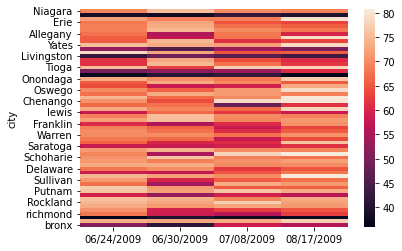

In [42]:
sns.heatmap(s_df[df.columns[1:]])

<AxesSubplot:ylabel='city'>

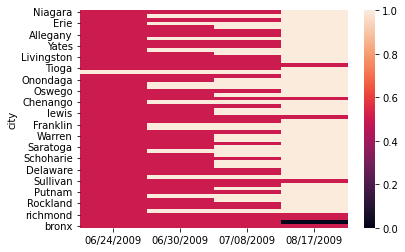

In [43]:
sns.heatmap(df.set_index(['city']))

In [44]:
df

,city,06/24/2009,06/30/2009,07/08/2009,08/17/2009
0,Niagara,0.5,0.5,0.5,1.0
1,Genesee,0.5,1.0,1.0,1.0
2,Wyoming,0.5,0.5,0.5,1.0
3,Erie,0.5,1.0,1.0,1.0
4,Chautauqua,0.5,0.5,1.0,1.0
5,Cattaraugus,0.5,0.5,0.5,1.0
6,Allegany,0.5,0.5,0.5,1.0
7,Monroe,0.5,1.0,1.0,1.0
8,Steuben,0.5,0.5,0.5,1.0
9,Yates,0.5,0.5,0.5,1.0
